# How Variable Is Your CNN, Really?

I train a CNN on MNIST. It gets 98.5% accuracy. I write that number in my report.

But here's what I started wondering: what if I trained it again? Same architecture, same data, same hyperparameters. Would I get the same 98.5%? Or would I get 97.8%? Or 99.1%?

This notebook answers that question. We'll train a simple CNN 10 times and see how much the results actually vary. Spoiler: it's probably more than you'd expect.

## Setup

We need ictonyx and TensorFlow. If you're in Colab, uncomment the pip install line.

In [ ]:
# !pip install ictonyx tensorflow

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input


import ictonyx as ix
from ictonyx import (
    ModelConfig, 
    KerasModelWrapper, 
    ArraysDataHandler,
    run_variability_study,
    plot_variability_summary
)

print(f"TensorFlow: {tf.__version__}")
print(f"Ictonyx: {ix.__version__}")

2026-02-10 06:42:58.883974: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-10 06:42:58.920718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-10 06:42:58.920745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-10 06:42:58.921960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-10 06:42:58.927627: I tensorflow/core/platform/cpu_feature_guar

TensorFlow: 2.15.0
Ictonyx: 0.0.5


## Load MNIST

The classic. 60,000 training images of handwritten digits, 10,000 test images. Each image is 28x28 grayscale.

In [2]:
# Load and preprocess MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1] and add channel dimension
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train[..., np.newaxis]  # Shape: (60000, 28, 28, 1)
X_test = X_test[..., np.newaxis]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

11490434/11490434 [==============================] - 1s 0us/step
Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


## Define the Model

A deliberately simple CNN. Two conv layers, one dense layer, softmax output. Nothing fancy — we're not trying to set records here, we're trying to understand variability.

In [3]:
def create_cnn(config: ModelConfig) -> KerasModelWrapper:
    """Build a simple CNN for MNIST classification."""
    
    model = Sequential([
        Input(shape=(28, 28, 1)),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return KerasModelWrapper(model)

# Quick sanity check
test_model = create_cnn(ModelConfig({}))
test_model.model.summary()

2026-02-10 06:43:16.633728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-10 06:43:16.700091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-10 06:43:16.702034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

## Configure the Study

We need two things:
1. A `ModelConfig` with training parameters
2. A `DataHandler` that knows how to serve our data

For this example, I'm using just 10,000 training samples to keep things fast. In a real study, you'd use the full dataset.

In [5]:
# Training configuration
config = ModelConfig({
    'epochs': 5,
    'batch_size': 64,
    'verbose': 0  # Suppress per-epoch output
})

# Data handler for numpy arrays
data_handler = ArraysDataHandler(X_train, y_train)

print(f"Training config: {config.epochs} epochs, batch size {config.batch_size}")
print(f"Data: {len(X_train)} samples")

Training config: 5 epochs, batch size 64
Data: 60000 samples


## Run the Variability Study

This is where ictonyx does its thing. We're going to train the same model architecture 10 times, each time with a fresh initialization. The library handles all the bookkeeping.

In [6]:
results = run_variability_study(
    model_builder=create_cnn,
    data_handler=data_handler,
    model_config=config,
    num_runs=10,
    epochs_per_run=5
)

print(results.summarize())

Loading and preparing data...
Array splits - Train: 42000, Val: 6000, Test: 12000
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 5
  Execution mode: in standard mode

 - Run 1: Training...


/home/appuser/projects/ictonyx/ictonyx/memory.py:192: UserWarning: TensorFlow setup failed: Physical devices cannot be modified after being initialized
  warnings.warn(f"TensorFlow setup failed: {e}")
/home/appuser/projects/ictonyx/ictonyx/runners.py:74: UserWarning: Memory setup incomplete. Consider using process isolation for better memory control: use_process_isolation=True
  warnings.warn(
2026-02-10 06:44:22.636678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2026-02-10 06:44:22.741025: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-02-10 06:44:22.990712: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-02-10 06:44:23.060039: I external/local_xla/xla/service/service.cc:168] XLA service 0x719ae46818b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devic

375/375 [==============================] - 0s 705us/step - loss: 0.0457 - accuracy: 0.9869
 - Run 1: Completed successfully
 - Run 2: Training...
375/375 [==============================] - 1s 3ms/step - loss: 0.0352 - accuracy: 0.9892
 - Run 2: Completed successfully
 - Run 3: Training...
375/375 [==============================] - 0s 959us/step - loss: 0.0378 - accuracy: 0.9879
 - Run 3: Completed successfully
 - Run 4: Training...
375/375 [==============================] - 0s 661us/step - loss: 0.0429 - accuracy: 0.9878
 - Run 4: Completed successfully
 - Run 5: Training...
375/375 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9812
 - Run 5: Completed successfully
 - Run 6: Training...
375/375 [==============================] - 0s 676us/step - loss: 0.0436 - accuracy: 0.9871
 - Run 6: Completed successfully
 - Run 7: Training...
375/375 [==============================] - 0s 680us/step - loss: 0.0415 - accuracy: 0.9887
 - Run 7: Completed successfully
 - R

## Visualize the Results

Numbers are fine, but a picture makes the variability visceral. The plot shows training curves for all runs, plus the distribution of final accuracies.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


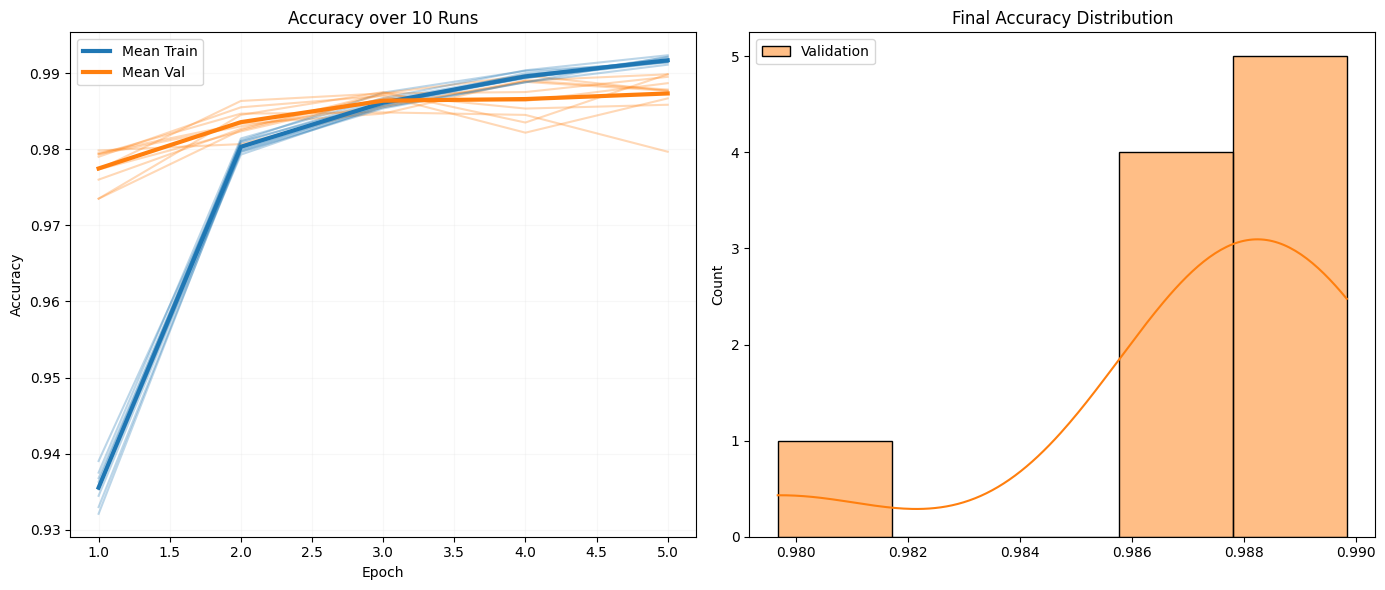

In [7]:
plot_variability_summary(
    all_runs_metrics_list=results.all_runs_metrics,
    final_metrics_series=results.final_val_accuracies,
    metric='accuracy'
)

## Dig Into the Numbers

The `results` object gives you access to all the raw data if you need it.

In [8]:
# Get the final validation accuracies
final_accs = results.final_val_accuracies

print("Final validation accuracy per run:")
for run_id, acc in final_accs.items():
    print(f"  {run_id}: {acc:.4f}")

print(f"\nSpread: {final_accs.max() - final_accs.min():.4f}")
print(f"This means your reported accuracy could reasonably vary by ~{(final_accs.max() - final_accs.min())*100:.1f} percentage points.")

Final validation accuracy per run:


AttributeError: 'list' object has no attribute 'items'

## What Does This Mean?

If you trained this model once and reported the result, you'd be giving an incomplete picture. The actual accuracy depends on the random initialization, the order of batches, and other stochastic factors.

With a variability study, you can report something more honest: the mean and standard deviation of accuracy across multiple runs. That's not just more rigorous — it's more useful for anyone trying to replicate or build on your work.

---

Next: [Comparing Two Architectures](./02_mnist_model_comparison.ipynb) — we'll see whether a different CNN architecture is *actually* better, or just got lucky on one run.